In [62]:
import os
import pickle
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from mne import create_info
from mne.io import RawArray

# --- User parameters: specify separately ---
ROOT              = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation"
PATIENT           = "Patient1"
DAY               = "day3"
BIG_TRIAL_IDX     = 1    # which interval in the big (day-level) pickle
MINI_TRIAL_IDX    = 2   # which interval in the mini pickle
TARGET_FS         = 500.0   # Hz for downsampling and HDF5 sampling
ELEC_CSV          = os.path.join(ROOT, "original_data", "electrodes_all_subj1.csv")
SESSION_NAME      = "P1_D3_Tsymptom_provocation_SUPENNS001R01"

# File paths
MAT_PATH  = os.path.join(ROOT, "Matlab_data_processed", PATIENT, f"{DAY}.mat")
BIG_PKL   = os.path.join(ROOT, "processed_data", "labels", f"{PATIENT}_{DAY}_intervals_new.pkl")
MINI_PKL  = os.path.join(ROOT, "processed_data", "labels", f"{SESSION_NAME}.pkl")
H5_PATH   = os.path.join(
    ROOT, "processed_data_upd", "processed_data", "ocd_symptom_provocation",
    f"{SESSION_NAME}.h5"
)

In [63]:
# %% [markdown]
# ## Cell 2 — Load MATLAB Trial

# %%
def load_matlab_trial(mat_path, trial_idx):
    try:
        m = loadmat(mat_path, struct_as_record=False, squeeze_me=True)
        ft = m.get("ftdata") or m.get("ftData")
        return ft.trial[trial_idx], float(ft.fsample)
    except NotImplementedError:
        with h5py.File(mat_path, "r") as f:
            grp = f.get("ftdata") or f.get("ftData")
            refs = grp["trial"][()]
            fs = float(np.array(grp["fsample"]).item())
            trials = [np.array(f[r]).T for r in refs.flatten()]
        return trials[trial_idx], fs

def downsample_data(data, orig_fs, target_fs):
    info = create_info(
        ch_names=[f"ch{i}" for i in range(data.shape[0])],
        sfreq=orig_fs,
        ch_types=["eeg"]*data.shape[0]
    )
    raw = RawArray(data, info)
    raw.resample(target_fs, npad="auto")
    return raw.get_data()

# def bipolar_reference(data, elec_csv):
#     elec_df = pd.read_csv(elec_csv)
#     names = elec_df["name"].astype(str).tolist()
#     mask = [(names[i][:2] == names[i+1][:2]) and (names[i]!="nan")
#             for i in range(len(names)-1)]
#     contig = np.where(mask)[0]
#     diff = data[1:,:] - data[:-1,:]
#     return diff[contig], [names[i] for i in contig]


def bipolar_reference(data, elec_csv=None):
    """
    No rereferencing: just return the raw data and generic channel names.
    """
    n_chans = data.shape[0]
    chan_names = [f"ch{i}" for i in range(n_chans)]
    return data, chan_names

def extract_interval(pkl_path, idx):
    with open(pkl_path, "rb") as f:
        iv = pickle.load(f)
    return float(iv.start[idx]), float(iv.end[idx])

def load_h5_segment(h5_path, start_sec, end_sec, fs):
    """
    Extracts an HD5 segment between start_sec and end_sec (in seconds),
    handling both 2D (time×channels) and 3D (1×channels×time) layouts,
    and returns an array of shape (channels, samples).
    """
    import h5py
    with h5py.File(h5_path, 'r') as f:
        ieeg = f['ieeg/data']
        print("HD5 raw ieeg/data shape:", ieeg.shape)

        # compute sample indices
        start_idx = int(start_sec * fs)
        end_idx   = int(end_sec   * fs)

        # pull out the raw array
        if ieeg.ndim == 3:
            # often (1, channels, samples)
            raw = ieeg[0, :, :]
        else:
            # yours is (samples, channels)
            raw = ieeg[...]

    # now raw is (samples, channels) if ndim==2 or (channels, samples) if ndim==3
    if raw.shape[0] > raw.shape[1]:
        # assume (time, channels)
        seg = raw[start_idx:end_idx, :]   # (samples, channels)
        seg = seg.T                       # → (channels, samples)
    else:
        # assume (channels, samples)
        seg = raw[:, start_idx:end_idx]   # (channels, samples)

    return np.array(seg)



def compute_corr(mat_ds, h5_seg):
    """
    Compute channel×channel Pearson r between mat_ds and h5_seg.
    Automatically transposes if array comes in as (T, chans).
    """
    def ensure_chan_time(arr):
        # if the “channel” dimension is larger than time, assume shape=(time, chans)
        if arr.shape[0] > arr.shape[1]:
            return arr.T
        return arr

    # 1) Make sure rows=channels, cols=time
    Y = ensure_chan_time(mat_ds)
    X = ensure_chan_time(h5_seg)

    # 2) Truncate to same length
    T = min(Y.shape[1], X.shape[1])
    Y = Y[:, :T]
    X = X[:, :T]

    # 3) Standardize
    Yz = (Y - Y.mean(axis=1, keepdims=True)) / Y.std(axis=1, keepdims=True)
    Xz = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

    # 4) Dot‐product → (n_hd5_chans × n_mat_chans)
    return (Xz @ Yz.T) / (T - 1)


In [64]:
# %% [markdown]
# ## Cell 3 — Bipolar Reference & Downsample MATLAB Data

# %%
# 1) Load raw MATLAB trial and fs
big_mat, fs_big = load_matlab_trial(MAT_PATH, BIG_TRIAL_IDX)
print(f"Loaded MATLAB big trial #{BIG_TRIAL_IDX}: shape={big_mat.shape}, fs={fs_big:.1f}Hz")

# Bipolar & downsample
# bip_diff, bip_chs = bipolar_reference(big_mat, ELEC_CSV)
# mat_ds_Big = downsample_data(bip_diff, fs_big, TARGET_FS)

"""just for testing: no rereferencing"""
raw_mat = big_mat  # no reref
chan_names = [f"ch{i}" for i in range(raw_mat.shape[0])]
mat_ds_big = downsample_data(raw_mat, fs_big, TARGET_FS)


print(f"Big trial DS: {mat_ds_Big.shape}, channels={len(bip_chs)}")


Loaded MATLAB big trial #1: shape=(176, 72000), fs=1200.0Hz
Creating RawArray with float64 data, n_channels=176, n_times=72000
    Range : 0 ... 71999 =      0.000 ...    59.999 secs
Ready.
Big trial DS: (162, 30000), channels=162


In [65]:
# %% [markdown]
# ## Cell 4 — Extract Interval Times

# Day‑level interval (big)
start_big, end_big = extract_interval(BIG_PKL, BIG_TRIAL_IDX)
print(f"Big interval #{BIG_TRIAL_IDX}: {start_big:.3f}s → {end_big:.3f}s")

start_min, end_min = extract_interval(MINI_PKL, MINI_TRIAL_IDX)
print(f"Mini interval #{MINI_TRIAL_IDX}: {start_min:.3f}s → {end_min:.3f}s")

Big interval #1: 165.372s → 225.372s
Mini interval #2: 258.601s → 318.601s


In [66]:
# %% [markdown]
# ## Cell 5 — Load HDF5 Segment

# %%
# %%
# Extract mini HDF5 segment
hd5_min = load_h5_segment(H5_PATH, start_min, end_min, TARGET_FS)
print(f"HD5 segment shape: {hd5_min.shape}")  # should be (n_channels, n_samples)

HD5 raw ieeg/data shape: (745300, 176)
HD5 segment shape: (176, 30000)


Correlation shape: (176, 162)


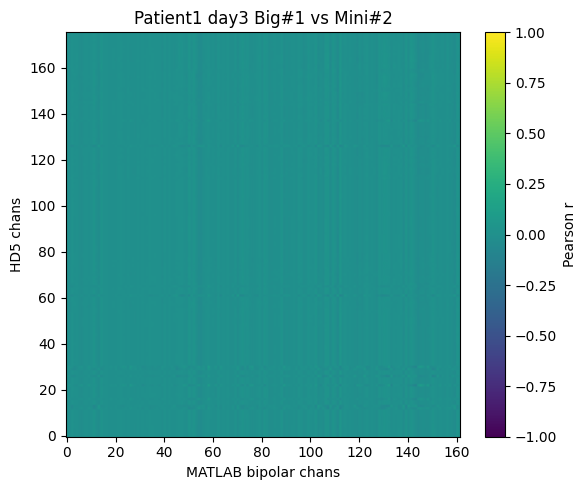

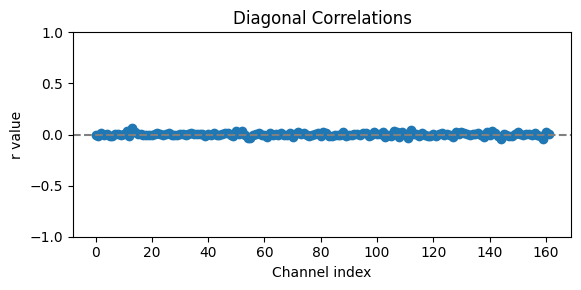

In [67]:
# %% [markdown]
# ## Cell 6 — Compute & Visualize Correlation
# ## Cell 6 — Compute & Visualize Correlations

# %%
# Correlate MATLAB vs mini HDF5
corr_min = compute_corr(mat_ds_Big, hd5_min)
print(f"Correlation shape: {corr_min.shape}")

plt.figure(figsize=(6,5))
plt.imshow(corr_min, origin="lower", aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.title(f"{PATIENT} {DAY} Big#{BIG_TRIAL_IDX} vs Mini#{MINI_TRIAL_IDX}")
plt.xlabel("MATLAB bipolar chans")
plt.ylabel("HD5 chans")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(np.diag(corr_min), marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Diagonal Correlations")
plt.xlabel("Channel index")
plt.ylabel("r value")
plt.ylim(-1,1)
plt.tight_layout()
plt.show()
